#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


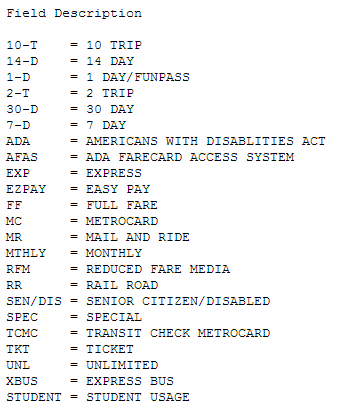

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

##note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

#Task 1: 
##Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Identify it and figure out what it is due to.


#Task 2: 
##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. By how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


#Task 3:
##Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


#EXTRA CREDIT: Cluster. 
##Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
##Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

##I am flattening the first 2 dimensions of the cube to cluster all light curves (time series) for all stations and all types

tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

##removing empty light curves
tots = tots[tots.std(1)>0]

##with Kmeans you have to choose the number of clusters ahead km = 

KMeans(n_clusters=10)

##and standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

##then you can run:

km.fit(vals)

#HINTS: 

###When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor of 600! (or even better you could take a weighted average)


#Possibly useful functions

###I used a variety of functions, most of them you are familiar with already. Here are a few that you may not have encountered yet which I used. 

* the numpy function np.where() returns the index where a condition is true. it is slow and inefficient but very intuitive and convenient


* the numpy functions np.nansum(), np.sum(), np.nanmean() etc. take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
     
     np.fft.rfft(mydata) 
     
     will return the fourier transform, but what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

     np.fft.rfftfreq(N, d) 
     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the Sample spacing, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1)


*  the np.array.flatten() and np.array.reshape() allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series)



In [3]:
import numpy as np
import pylab as pl
import pandas as pd
%pylab inline
import datetime
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

Populating the interactive namespace from numpy and matplotlib


In [4]:
#after reading the datacube you should see:
mtainit = np.load('/Users/mariaortiz/PUI2015_mortiz/HW6/MTA_Fare.npy')
print mtainit[50]
mtainit.shape


[[71755 79961 84841 ..., 86657 84563 82271]
 [ 3531  4205  4377 ...,  4868  4865  4906]
 [  215   204   234 ...,   284   299   320]
 ..., 
 [    0     0     0 ...,     0     0     0]
 [    0     0     0 ...,     0     0     0]
 [   -1    -1    -1 ...,  4285  4702  1448]]


(600, 23, 194)

In [5]:
#using where to replace the -1 with NaN
mta = where(mtainit<0, 'NaN', mtainit)
#looking at shape
mta.shape
#print mta

(600, 23, 194)

Above, we get an array of 600 stations, 23 card types for 194 weeks


Below, ride types list

In [6]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print ridetype

['10t' '14d' '1d' '2t' '30d' '7d' 'ada' 'afas' 'exp' 'ez' 'ff' 'mc' 'mr'
 'month' 'rfm' 'rr' 'sen' 'spec' 'tcmc' 't' 'umlim' 'xbus' 'stud']


In [7]:
#mortiz attempts, left here for future reference, ignore this!
#from datetime import date
#start = date(2010, 5, 21)
#end = date(2015, 2, 21)
#mtarange = pd.date_range(start, end, 1)

#mtarange = DateRange(start, end, offset==1)
#dates = pd.date_range(start, end, 1)

In [8]:
#creating range of dates, 194 weeks
mtarange = pd.date_range('05/21/2010', periods=194, freq='W')
mtarange.shape

(194,)

#Task 1

- Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
- Figure out what it is due to.

FB: The Numpy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. 

In [9]:
#first changing data to float to be able to manipulate
mta = mta.astype(float)
#using the NaN enabled Numpy functions
mtastations = np.nansum(mta, axis=1)
mtastations.shape
#output shows we did this correctly as now we have data for the 600 stations across 194 weeks

(600, 194)

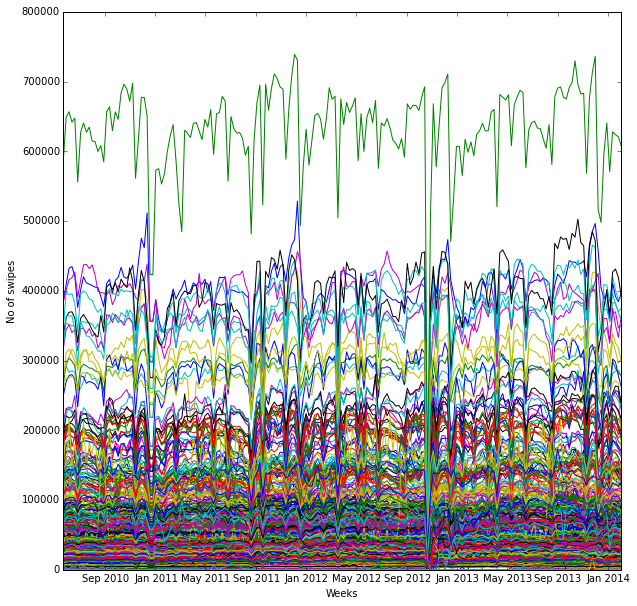

In [10]:
plt.figure(figsize=(10, 10), dpi=200)
ax = pl.plot(mtarange, np.transpose(mtastations))
#we used transpose to get the time on the x axis
pl.ylabel('No of swipes')
pl.xlabel('Weeks')
#pl.xticks(mtarange, fontsize=20)

In [11]:
#finding mean and stdv to make the thresholds
mtastationsmeans = np.nanmean(mtastations, axis = 1)
#mtastationsmeans.shape
mtastationsstd = np.nanstd(mtastations, axis = 1)
#mtastationsstd.shape

In [12]:
#creating upper and lower thresholds in arrays, mean + 3 sigma 
thresholdsupper = mtastationsmeans + 3*mtastationsstd
thresholdslower = mtastationsmeans - 3*mtastationsstd 
#print thresholds
thresholdslower.shape
thresholdsupper.shape


(600,)

In [13]:
#locupper = np.where(mtastations < thresholdsupper)
#loclower = np.where(mtastations > thresholdslower)


In [14]:
#locate the weeks that exceed the thresholds
sigs = [np.where(ts < thresholdslower[i]) for i,ts in enumerate(mtastations)]
print sigs[0]

(array([127, 128, 129, 130]),)


###We can see in October 2012 there is a huge dip in ridership, this is because of Superstorm Sandy.



#Questions
- how to fix x labels
- Coding thresholds to locate events, FB used the loc function, but we can't seem to make it work

#Task 2: stationarity and trends

- Identify the ridership types that have steadily increased in popularity, and that have steadily decreased
- By how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [15]:
#import scikits.timeseries as ts
#ts = Series(randn(len(mtarange)), index=mtarange)

In [16]:
#same as we did above, now using ridertype, so we sum on axis = 0, which refers to the 23 types
mtaridertype = np.nansum(mta, axis=0)
mtaridertype.shape

(23, 194)

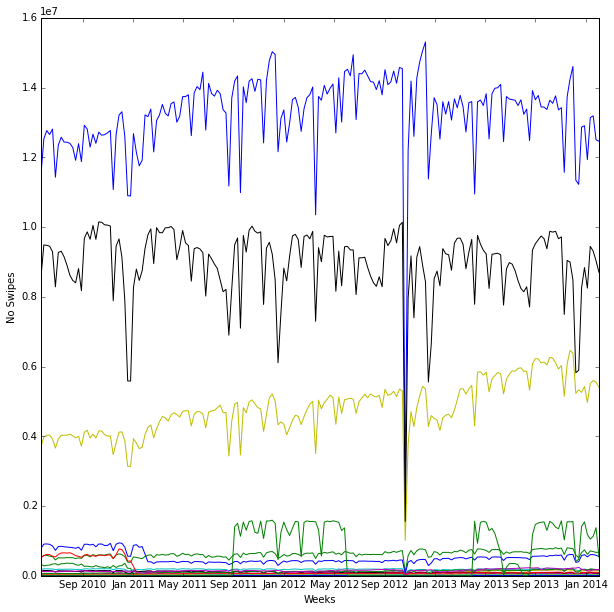

In [17]:
plt.figure(figsize=(10, 10), dpi=200)
#figsize=(100,100)
ax = pl.plot(mtarange, np.transpose(mtaridertype))
pl.ylabel('No Swipes')
pl.xlabel('Weeks')
#pl.xticks(mtarange, fontsize=20)

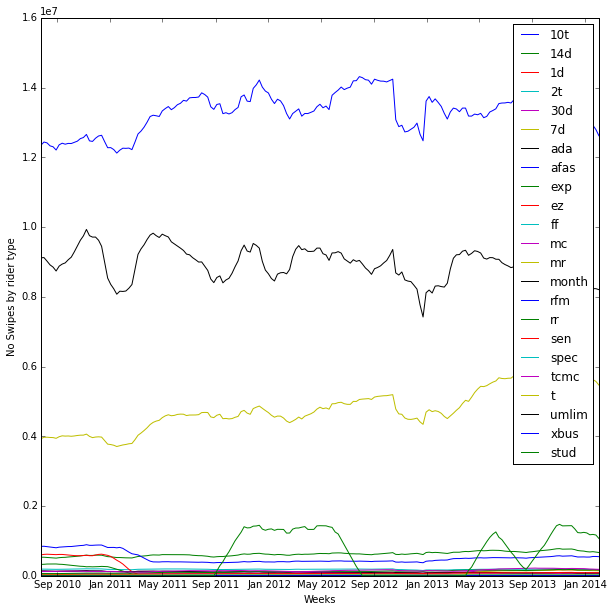

In [18]:
plt.figure(figsize=(10, 10), dpi=200)
#figsize = (100,100)
smoothridertypes = pd.rolling_mean(np.transpose(mtaridertype), 10)
ax = pl.plot(mtarange, smoothridertypes)
pl.ylabel('No Swipes by rider type')
pl.xlabel('Weeks')
pl.legend(ridetype)
#pl.xticks(mtarange, fontsize=20)

###can we plot the top 4 rider types to get a better look a them?

In [19]:
#check ratio for beginning of time series compared to end of time series
rollingratio = smoothridertypes[10,:]/smoothridertypes[193,:]
#we want to look at 4 specific ridertypes as they seem to have the most changes at the beginning and end
#(eyeballing it!)
print rollingratio

[  9.85855761e-01   7.96898334e-01   9.01896857e-01   1.07217516e+00
   9.83155326e-01   7.26253084e-01   1.11214933e+00   4.80765217e+03
   9.42633429e+04   6.82381556e+05   1.23714609e+00   8.30622261e-01
   3.89558171e-05   1.74222625e+00   1.54426917e+00   3.87513943e-01
   3.47208425e-01   5.46373828e-02   6.53059649e-01   9.80984190e-01
   1.26020779e+00   6.18746842e-01   0.00000000e+00]


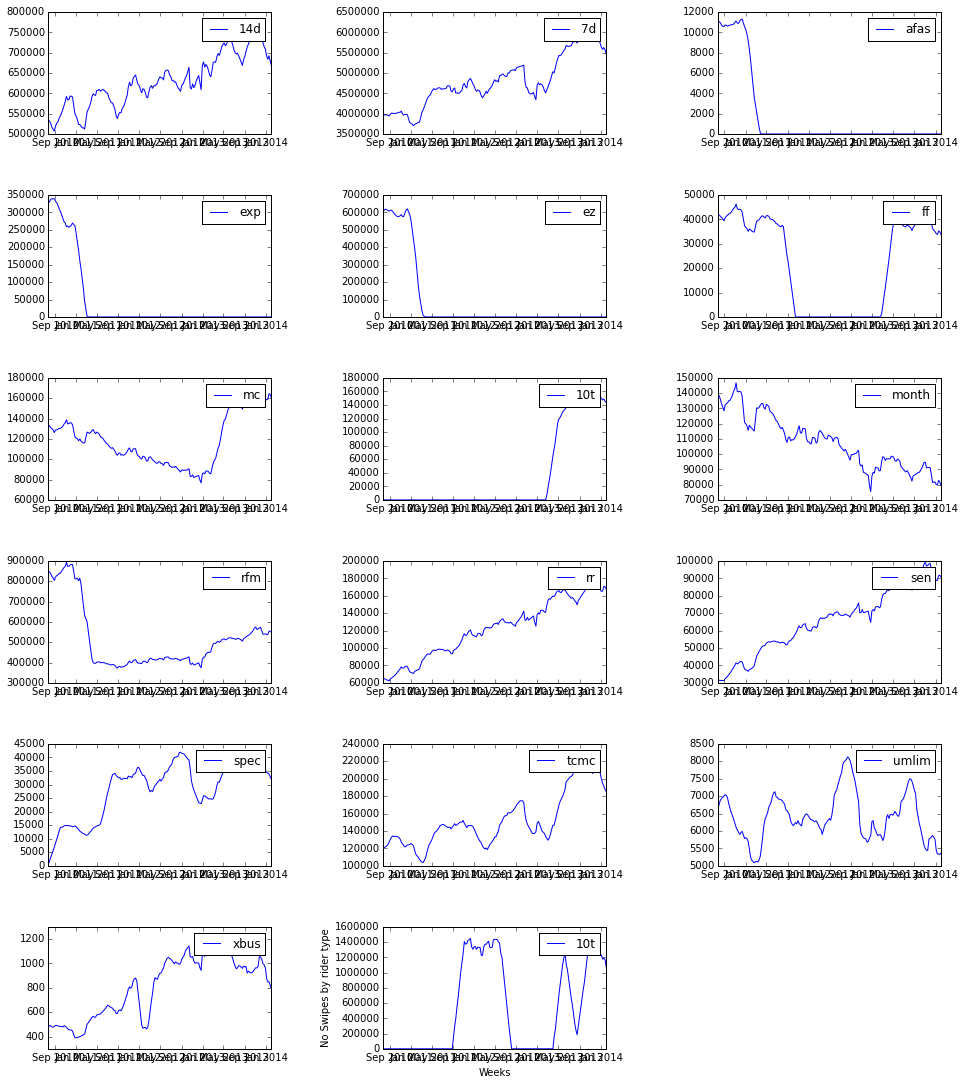

In [20]:
#looking at the first elements of the array, we can see we should eliminate the ones between .9 and 1.1, because 
#this indicates a ratio closer to 1 of no significant change
#items to eliminate 0, 2, 3, 4, 6, 19 

#here we use the rolling mean
plt.figure(figsize=(16, 16), dpi=200)
smoothridertypes = pd.rolling_mean(np.transpose(mtaridertype), 10)
#we want to look at 4 specific ridertypes as they seem to have the most changes at the beginning and end
#(eyeballing it!)
#we should have plotted in a for loop, the code below is not very pythonic...

pl.subplot(6,3,1)
ax = pl.plot(mtarange, smoothridertypes[:, 1])
pl.legend(ridetype[1:])
#trying to fix axis
#pl.xaxis.set_ticks(range(1,6))
#pl.xaxis.set_ticklabels('S 2010', 'M 2011', 'J 2012', 'S 2012', 'M 2013', 'J 2014')

pl.subplot(6,3,2)
ax = pl.plot(mtarange, smoothridertypes[:, 5])
pl.legend(ridetype[5:])

pl.subplot(6,3,3)
ax = pl.plot(mtarange, smoothridertypes[:, 7])
pl.legend(ridetype[7:])

pl.subplot(6,3,4)
ax = pl.plot(mtarange, smoothridertypes[:, 8])
pl.legend(ridetype[8:])

pl.subplot(6,3,5)
ax = pl.plot(mtarange, smoothridertypes[:, 9])
pl.legend(ridetype[9:])

pl.subplot(6,3,6)
ax = pl.plot(mtarange, smoothridertypes[:, 10])
pl.legend(ridetype[10:])

pl.subplot(6,3,7)
ax = pl.plot(mtarange, smoothridertypes[:, 11])
pl.legend(ridetype[11:])

pl.subplot(6,3,8)
ax = pl.plot(mtarange, smoothridertypes[:, 12])
pl.legend(ridetype)

pl.subplot(6,3,9)
ax = pl.plot(mtarange, smoothridertypes[:, 13])
pl.legend(ridetype[13:])

pl.subplot(6,3,10)
ax = pl.plot(mtarange, smoothridertypes[:, 14])
pl.legend(ridetype[14:])

pl.subplot(6,3,11)
ax = pl.plot(mtarange, smoothridertypes[:, 15])
pl.legend(ridetype[15:])

pl.subplot(6,3,12)
ax = pl.plot(mtarange, smoothridertypes[:, 16])
pl.legend(ridetype[16:])

pl.subplot(6,3,13)
ax = pl.plot(mtarange, smoothridertypes[:, 17])
pl.legend(ridetype[17:])

pl.subplot(6,3,14)
ax = pl.plot(mtarange, smoothridertypes[:, 18])
pl.legend(ridetype[18:])

pl.subplot(6,3,15)
ax = pl.plot(mtarange, smoothridertypes[:, 20])
pl.legend(ridetype[20:])

pl.subplot(6,3,16)
ax = pl.plot(mtarange, smoothridertypes[:, 21])
pl.legend(ridetype[21:])

pl.subplot(6,3,17)
ax = pl.plot(mtarange, smoothridertypes[:, 22])
pl.legend(ridetype[22:])

pl.ylabel('No Swipes by rider type')
pl.xlabel('Weeks')
pl.legend(ridetype)

pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, top=1, bottom=.1)

###Visual inspection of the rider types show us that:
- 14 day [1], 7 day [5], rail road [15], senior [16], special [17], tcmc [18], and express bus [21] pass ridership increased
- monthly pass [13] decreased, possibly because it was phased out and subsituted for the 30 day unlimited

In [21]:
myratios = [1, 5, 13, 15, 16, 17, 18, 21]

for n in myratios:
    if n != 13:
        print '%s passes are increasing at a rate of %f.' % (ridetype[n], rollingratio[n])
    else:
        print '%s passes are decreasing at a rate of %f.' % (ridetype[n], rollingratio[n])

14d passes are increasing at a rate of 0.796898.
7d passes are increasing at a rate of 0.726253.
month passes are decreasing at a rate of 1.742226.
rr passes are increasing at a rate of 0.387514.
sen passes are increasing at a rate of 0.347208.
spec passes are increasing at a rate of 0.054637.
tcmc passes are increasing at a rate of 0.653060.
xbus passes are increasing at a rate of 0.618747.


#Questions
- How to grab specific user types, I was just counting from the ridertypes array established at the beginning..


ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])


#Task 3: Periodicity
- Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). 

In [31]:
#here we use the Fourier Transformation to find periodicity, and we need to look at the absolute value
#rfft is using the real part of the Fourier transfer
#python module takes fft.rfft takes n (window lenght), d (sample space)
f = np.abs(np.fft.rfft(mtastations))
f.shape

#line above is important, here you take the 'power' of the data
#our output is 98 because we are only looking at the 'positive waves'
#f2 = np.fft.fft(mtastations)
#f2.shape


(600, 98)

A FT is used to detect a period when we don't know anything about the period. The min number of points you use to detect a frequency is twice your sampling rate. Each frecuency tells you how much power, measure of weather or not there is a period at this particular frecuency, y axis of fourier transform is... 


In [23]:
#fourier transform taking absolute values, which is why our array is halved
ffreq = np.fft.rfftfreq(194, d=1.0)
ffreq.shape

(98,)

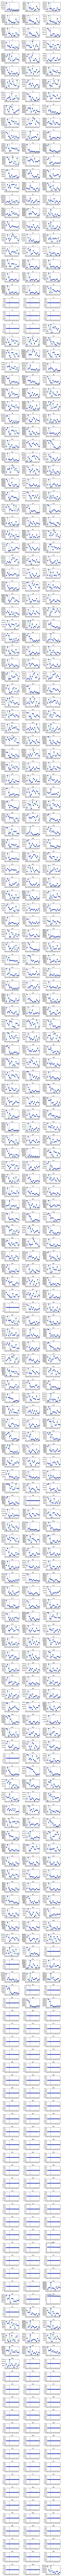

In [29]:
fig = plt.figure(figsize=(10,400))
mtastations = pd.DataFrame(mtastations)

#making 600 plots in for loop
for i in range(600):
    ax = fig.add_subplot(200,3,i)
    f = np.abs(np.fft.rfft(mtastations.loc[i,:]))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], 'o', ms = 8)
    ax.set_title("%i" %(i-1))
    ax.plot(np.fft.rfftfreq(194, 1.0)[1:], (f)[1:], '-')
    ax.set_xlim(0,1.0/15)
    plt.axvline(1.0/52)
    pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, top=1, bottom=.1)

###Looking at station plots
- Visually inspecting the plots, we have that stations 599, 326, 193 and 149 have over 2.5 million rides, thus show the most prominent periodic trend 

#FB NOTES BELOW....

In [25]:
#in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
#all time series, each station each ride type, look like this (pretty ugly)

##NOTE ON THE TREND DETECTION:
###you should find the ride type that has the steepest increase, and the steepest decrease. notice: we are looking for something that has a more or less constant trend

###to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

###you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the flux near the beginning to the flux near the end of the time series.

###notice that you should inspect the time series, either algorithmically or by eye, to ensure you see a trend, and not just changing structure.


###below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

##to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
##an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.